In [1]:
import numpy as np
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
import pickle

from environment import TrafficEnv
from ml_controller import Controller

In [2]:
def make_epsilon_greedy_policy(Q, epsilon, num_actions):
    def policy_fn(observation):
        actions = np.ones(num_actions, dtype=float) * epsilon / num_actions
        best_action = np.argmax(Q[observation])
        actions[best_action] += (1.0 - epsilon)
        return actions
    return policy_fn

In [3]:
def q_learning(Q, env, num_episodes, group_size, disc_factor=0.95, alpha=0.3, epsilon=0.001):
    stats = {'episode_lengths': np.zeros(num_episodes)}
    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.num_actions)
    avg_len = 0
    
    for i_ep  in range(num_episodes):
        # Display episode number every so often
        if (i_ep + 1) % group_size == 0:
            prev_avg = avg_len
            avg_len = sum(stats['episode_lengths'][i_ep - group_size - 1:i_ep - 1]) / group_size
            avg_diff = avg_len - prev_avg
            print("\rEpisode {}/{}, Latest Average {}, Average change {}".format(
                i_ep + 1, num_episodes, avg_len, avg_diff), end="")
        
        prev_state = tuple(env.reset())
        
        for t in itertools.count():
            action_probs = policy(prev_state)
            action = np.random.choice(np.arange(env.num_actions), p=action_probs)
            reward, done = env.step(action)
            next_state = tuple(env.state)
            
            stats['episode_lengths'][i_ep] = t
            
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + disc_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[prev_state][action]
            Q[prev_state][action] += alpha * td_delta
            
            if done:
                break
            
            prev_state = next_state
    return Q, stats

In [4]:
def dd():
    return np.zeros(6)

In [101]:
max_cars = 5
episode_length = 100
group_size = 5

In [6]:
env = TrafficEnv()
controller = Controller(env, max_cars)

# Q maps the state -> (action -> action-value)
Q = defaultdict(dd)

In [ ]:
Q, stats = q_learning(Q, controller, episode_length, group_size)

Episode 65/100, Latest ep len 40412.4, Average change 30129.4000000000004

In [98]:
ep_len = stats['episode_lengths']
avg_ep_len_arr = []
for ep_range in range(0, episode_length, group_size):
    avg_ep_len = sum(ep_len[ep_range:ep_range+group_size]) / group_size
    avg_ep_len_arr.append(avg_ep_len)

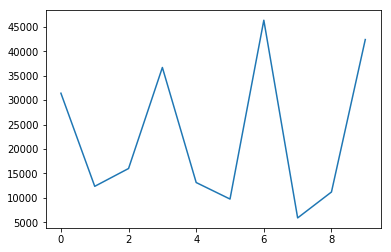

In [99]:
plt.plot(list(range(len(avg_ep_len_arr))), avg_ep_len_arr)

In [100]:
pickle.dump(Q, open('policy.p', 'wb'))

In [59]:
Q = pickle.load(open('policy.p', 'rb'))

In [11]:
sim_env = TrafficEnv()
sim = Controller(sim_env, max_cars)

In [95]:
total_cars = 0
sim.reset()
for _ in range(500):
    best_action = np.argmax(Q[sim.state])
    print(f'The lane state is {sim.lane_state}')
    print(f'The state is {sim.state}')
    rewards, done  = sim.step(best_action)
    total_cars += sum(sim.lane_state)
    print(f'The action returns are {list(Q[sim.state])}')
    print(f'The action taken was {best_action}')
    print()
    if done:
        print('Model ended prematurely')
        break

print(f'The model survived for {_} seconds')
avg_cars = total_cars/_
print(f'Average cars during runtime: {avg_cars}')

The lane state is (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
The state is (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
The action returns are [-6.103823793275687, -6.3435062355214775, -6.127473317970437, -6.139421125869009, -5.900233816028574, -6.23093027973497]
The action taken was 0

The lane state is (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)
The state is (0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0)
The action returns are [-4.6590291884882475, -4.770855218284714, -4.681261954914867, -4.909675506234518, -4.190926472915887, -4.922968735585453]
The action taken was 4

The lane state is (1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0)
The state is (1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 4.0)
The action returns are [-5.529109663101544, -5.5004495182244835, -5.640553420442184, -5.478011786945902, -5.547447800292254, -5.414186940035471]
The action taken was 4

The lane state is (0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)
The state is (0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 4.0)
The action returns are [-3.857393301407373, -3.690641572863716, -3.74710100356

The state is (0.0, 3.0, 1.0, 3.0, 0.0, 4.0, 4.0)
The action returns are [-1.7199639384674175, -1.1709907079790507, -1.7018891201999562, -0.8405214637918366, -1.0058090867801892, -0.15795009490260664]
The action taken was 5

The lane state is (1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1)
The state is (1.0, 3.0, 2.0, 3.0, 2.0, 4.0, 5.0)
The action returns are [-3.705628886781579, -3.760425604586848, -3.733950943340776, -3.6911266410998094, -3.696265997038613, -3.339359122036006]
The action taken was 5

The lane state is (1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1)
The state is (1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 5.0)
The action returns are [-2.2893483721300516, -2.5169806668903676, -2.3428078551563276, -2.6061394840591294, -2.088607400789845, -1.6335199915411809]
The action taken was 5

The lane state is (1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1)
The state is (2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 5.0)
The action returns are [-3.6227541013787867, -3.588809215623152, -3.6254540832739632, -3.6899014460783395, -3.063729185397